In [24]:
#Import Modules
import datacube
import datetime
import fiona
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio.mask
import rasterio.features
from shapely import geometry
import seaborn as sns
import sys
import xarray as xr

import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from datacube.storage import masking
from datacube.utils import geometry
from datacube.helpers import ga_pq_fuser, write_geotiff
from datacube.helpers import write_geotiff

sys.path.append('/g/data/u46/users/ck9738/10_Scripts')
import BandIndices

dc = datacube.Datacube(app='tcw')

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
#define area of interest
query = {
    
        #Mathoura Large
# 'y': (-35.6545, -36.0320),
# 'x': (144.8179, 145.4289), 
    
    
            #Moria Lakes
# 'y': (-35.9634, -35.8515),
# 'x': (144.8887, 145.0738),
    
                #lake Frome
# 'y': (-30.354, -30.889),
# 'x': (139.482, 140.032),

        #lake carnegie
'y': (-36.900, -36.988),
'x': (149.800, 149.925),
    
    
'time': ('2017-03-28', '2017-05-30'),
'crs': 'EPSG:4326',
'output_crs': 'EPSG: 3577',
'resolution': (-25, 25)
}
    

In [26]:
#load data
data_lst8 = dc.load(product='ls8_nbart_albers', group_by='solar_day', **query)
data_lst8.isel(time=0)

<xarray.Dataset>
Dimensions:          (x: 498, y: 449)
Coordinates:
    time             datetime64[ns] 2017-03-28T23:50:17
  * y                (y) float64 -4.144e+06 -4.144e+06 ... -4.155e+06 -4.155e+06
  * x                (x) float64 1.585e+06 1.585e+06 ... 1.597e+06 1.597e+06
Data variables:
    coastal_aerosol  (y, x) int16 284 295 313 314 295 ... 373 367 376 382 379
    blue             (y, x) int16 192 210 218 228 208 ... 252 247 250 250 240
    green            (y, x) int16 254 272 307 306 273 ... 183 190 190 186 191
    red              (y, x) int16 210 234 273 292 250 206 ... 87 83 81 84 84 84
    nir              (y, x) int16 1686 1621 1800 1834 1769 ... 52 48 51 51 44
    swir1            (y, x) int16 847 947 1097 1183 1056 838 ... 16 21 18 17 20
    swir2            (y, x) int16 384 436 514 571 495 385 ... 14 14 15 12 11 16
Attributes:
    crs:      EPSG: 3577

In [27]:
#define number of total observations

total_obs = int(len(data_lst8.time))
total_obs

8

In [28]:
#turn terrain masked values form -999 to Nan

want_to_mask = (data_lst8 == -999).to_array(dim='variables').all(dim='variables')
terrain_out = data_lst8.where(~want_to_mask, np.NaN)

In [29]:
#load PG
sensor_pq = dc.load(product='ls8_pq_albers', fuse_func=ga_pq_fuser, group_by='solar_day', **query)
sensor_pq

<xarray.Dataset>
Dimensions:       (time: 8, x: 498, y: 449)
Coordinates:
  * time          (time) datetime64[ns] 2017-03-28T23:50:17 ... 2017-05-24T23:44:27
  * y             (y) float64 -4.144e+06 -4.144e+06 ... -4.155e+06 -4.155e+06
  * x             (x) float64 1.585e+06 1.585e+06 ... 1.597e+06 1.597e+06
Data variables:
    pixelquality  (time, y, x) int16 16383 16383 16383 ... 15871 15871 15871
Attributes:
    crs:      EPSG: 3577

In [30]:
# #load wofs filtered summary
wofs_filtered_summary= dc.load(product = 'wofs_annual_summary', **query)
wofs_filtered_summary

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*

In [31]:
#Mask Cloud

#make Mask
good_quality = masking.make_mask(sensor_pq.pixelquality,
                                 cloud_acca='no_cloud',
                                 cloud_fmask='no_cloud',
                                 cloud_shadow_acca='no_cloud_shadow',
                                 cloud_shadow_fmask='no_cloud_shadow',
                                 blue_saturated=False,
                                 green_saturated=False,
                                 red_saturated=False,
                                 nir_saturated=False,
                                 swir1_saturated=False,
                                 swir2_saturated=False,
                                 contiguous=True)
good_quality

<xarray.DataArray 'pixelquality' (time: 8, y: 449, x: 498)>
array([[[ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True],
        ...,
        [ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True]],

       [[ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True],
        ...,
        [ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True]],

       ...,

       [[ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True],
        ...,
        [ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True]],

       [[ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True],
        ...,
        [ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True]]])
Coordinates:
  * time     (time) datetime64[ns] 2017-03-28T23:50:17 ... 2017-05-24T23:44:27
  * y        (y) float64 -4.144e+06 -4.144e+06 ... -4.155e+06 -4.155e+06
  * x        (

In [32]:
#apply Mask
Masked_lst8_data = terrain_out.where(good_quality)

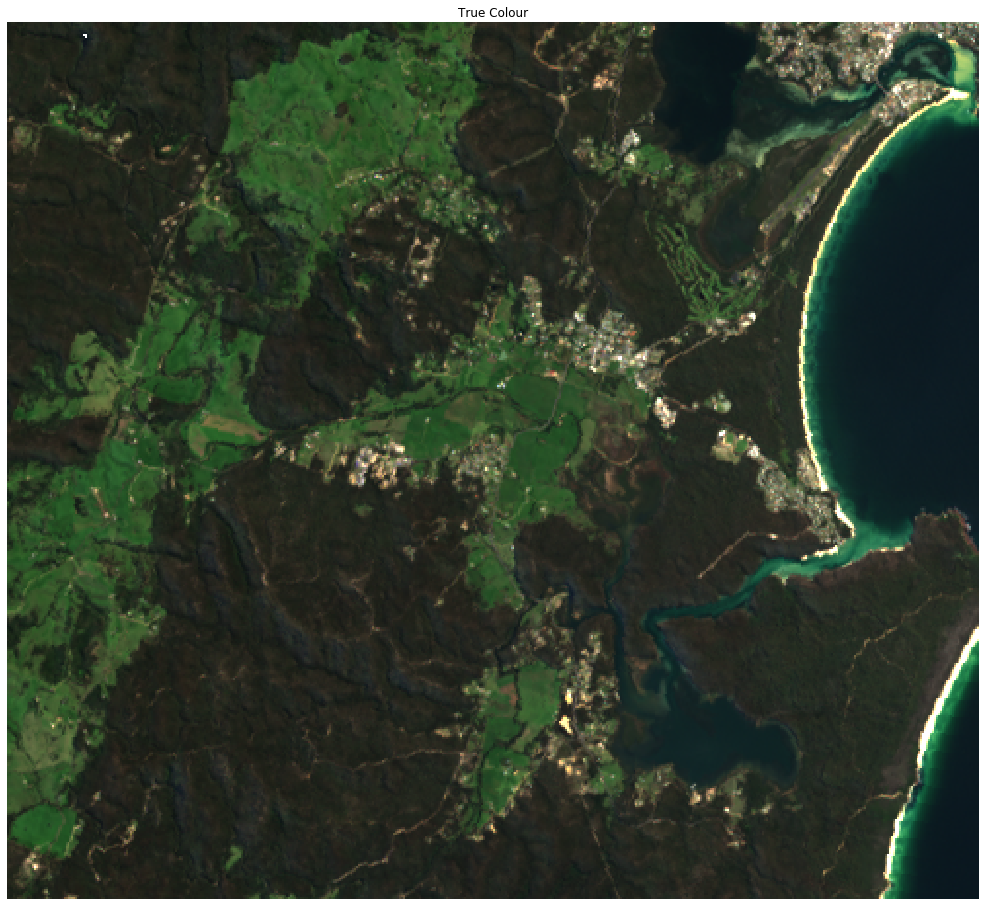

In [33]:
data_lst8_once = Masked_lst8_data.isel(time=0)

#Prepare geomedian imagery for plotting

rgb = data_lst8_once.to_array(dim='color').sel(color=[
    'red','green', 'blue']).transpose('y', 'x', 'color')
fake_saturation = 2000.0  #you may need to adjust this to get a clear image. higher numbers will make it darker, 
                                                                            #lower will make it ligher
rgb = rgb.astype('double')
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

fig = plt.figure(figsize =(15,15)) #edit size of plot 
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #set border dimensions
fig.patch.set_facecolor('white') #make border white 
fig.patch.set_alpha(0.99)#ensure border white
plt.axis('off')#remove axis 
plt.title('True Colour') #add title
plt.imshow(scaled, interpolation = 'nearest') #create image

In [34]:
#Do tassled Cap transformation
TCI = BandIndices.tasseled_cap(Masked_lst8_data, tc_bands=['wetness'], drop=True)

tcw = TCI['wetness']




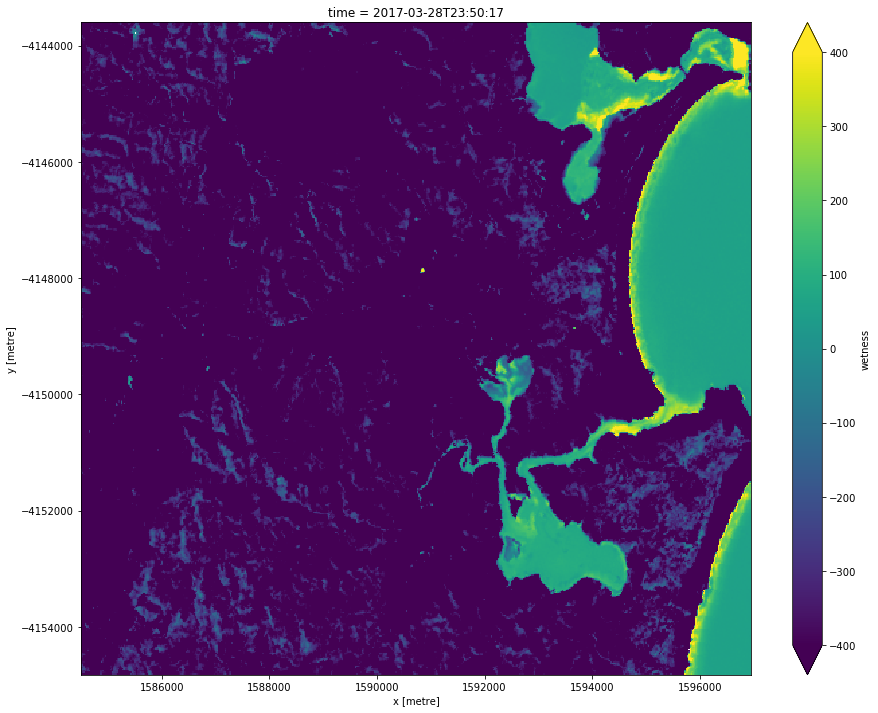

In [36]:
tcw.isel(time=0).plot(cmap='viridis', figsize =(15,12),vmin=-400)

In [39]:
#make Fisher index

lst_fisher = 1.7204 +((171*Masked_lst8_data['green'])+(3*Masked_lst8_data['red'])-(70*Masked_lst8_data['nir'])-(45*Masked_lst8_data['swir1'])-(71*Masked_lst8_data['swir2']))/10000
lst_fisher

<xarray.DataArray (time: 8, y: 449, x: 498)>
array([[[-12.2131, -12.2623, ..., -15.0416, -11.0332],
        [-12.7853, -12.3407, ..., -19.7186, -17.1967],
        ...,
        [-17.0837, -15.0712, ...,   4.3951,   4.3521],
        [-16.7562, -13.5903, ...,   4.4146,   4.5001]],

       [[-11.6536, -11.7005, ..., -18.9866, -15.7242],
        [-12.3938, -13.1593, ..., -14.0022, -19.2284],
        ...,
        [-15.4494, -15.5631, ...,   4.8607,   4.751 ],
        [-15.9786, -15.8027, ...,   4.8472,   4.7329]],

       ...,

       [[-13.7307, -13.7736, ..., -18.0988, -12.4794],
        [-15.4238, -14.1653, ..., -12.591 , -17.1173],
        ...,
        [-19.4946, -17.2717, ...,   5.8448,   5.891 ],
        [-19.647 , -15.1965, ...,   5.9005,   5.7831]],

       [[-13.8868, -12.9489, ..., -18.6239, -14.917 ],
        [-13.752 , -16.129 , ..., -15.6869, -16.9487],
        ...,
        [-18.511 , -18.9656, ...,   4.7838,   4.7774],
        [-20.5178, -18.0476, ...,   4.6986,   4.7777]]])
Co

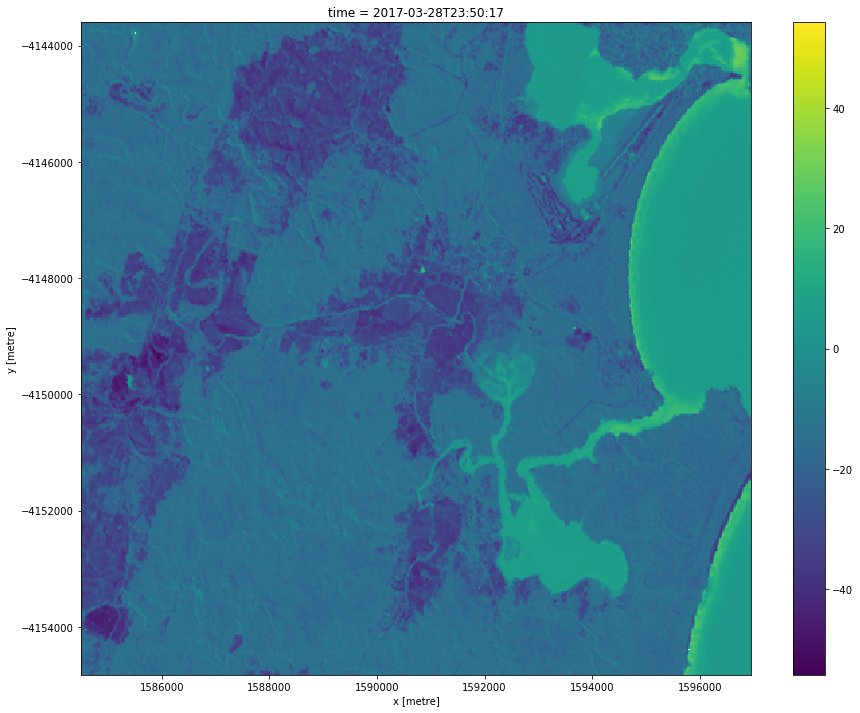

In [40]:
lst_fisher.isel(time=0).plot(cmap='viridis', figsize =(15,12))

In [15]:
inundated_veg_msk = (np.logical_and(lst_fisher>=-10,tcw>=-400))
inundated_veg = lst_fisher.where(inundated_veg_msk==True,0)
inundated_veg = inundated_veg.where(inundated_veg_msk==False,1)

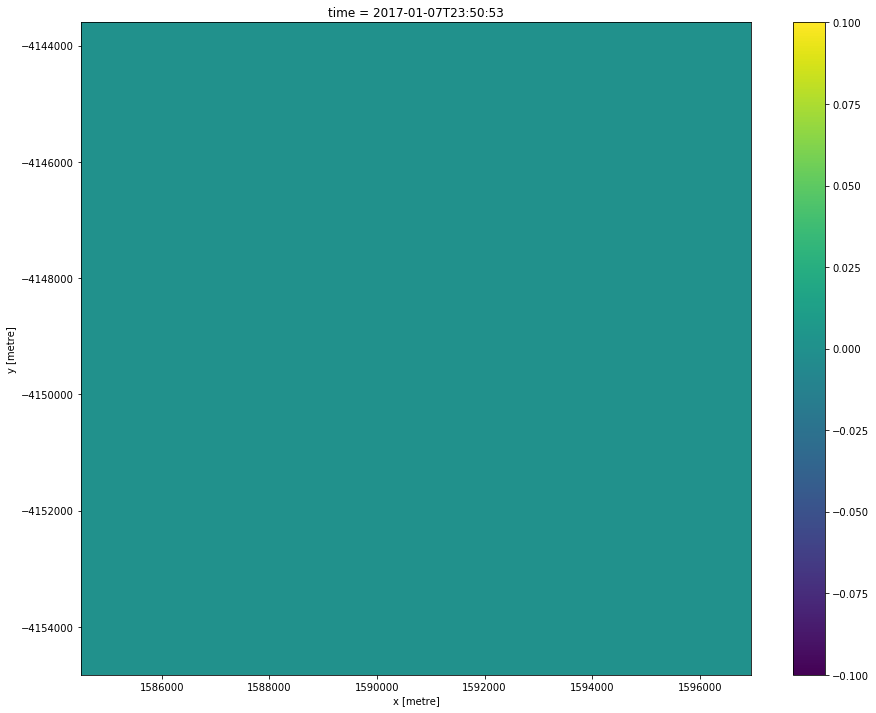

In [16]:
inundated_veg.isel(time=0).plot(cmap='viridis', figsize =(15,12))

In [17]:
wet_frequency = inundated_veg.sum(dim='time')

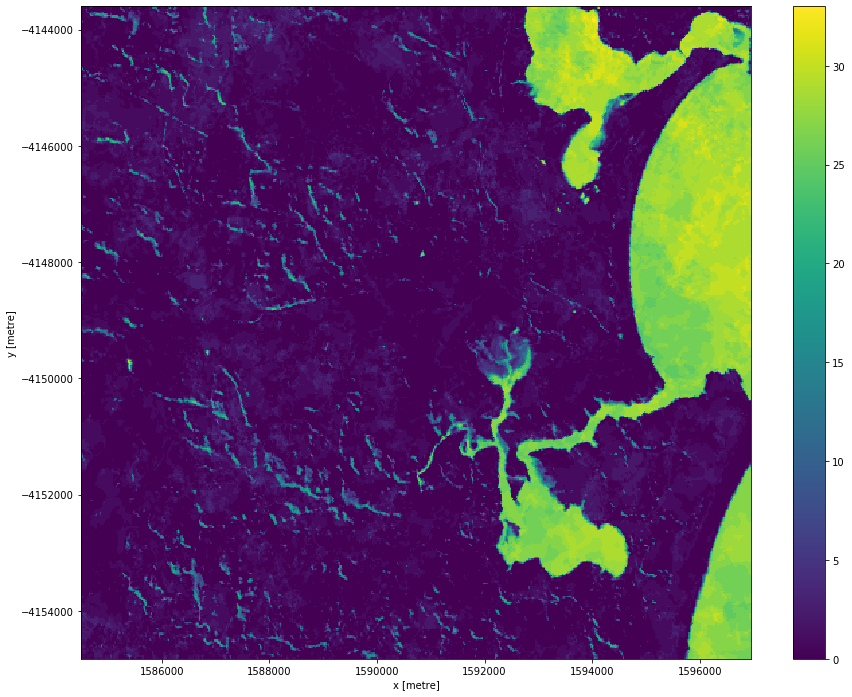

In [18]:
wet_frequency.plot(cmap='viridis', figsize =(15,12))

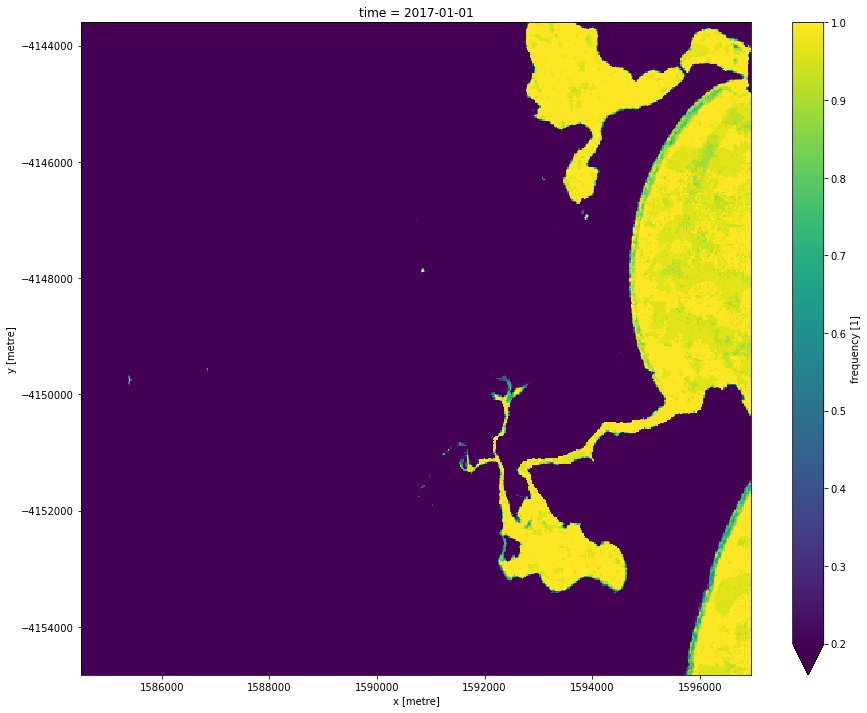

In [19]:
wofs_filtered_summary.frequency.plot(cmap='viridis',figsize =(15,12),vmin=0.2,)

In [20]:
precent_threhold = total_obs*0.2
precent_threhold

9.0

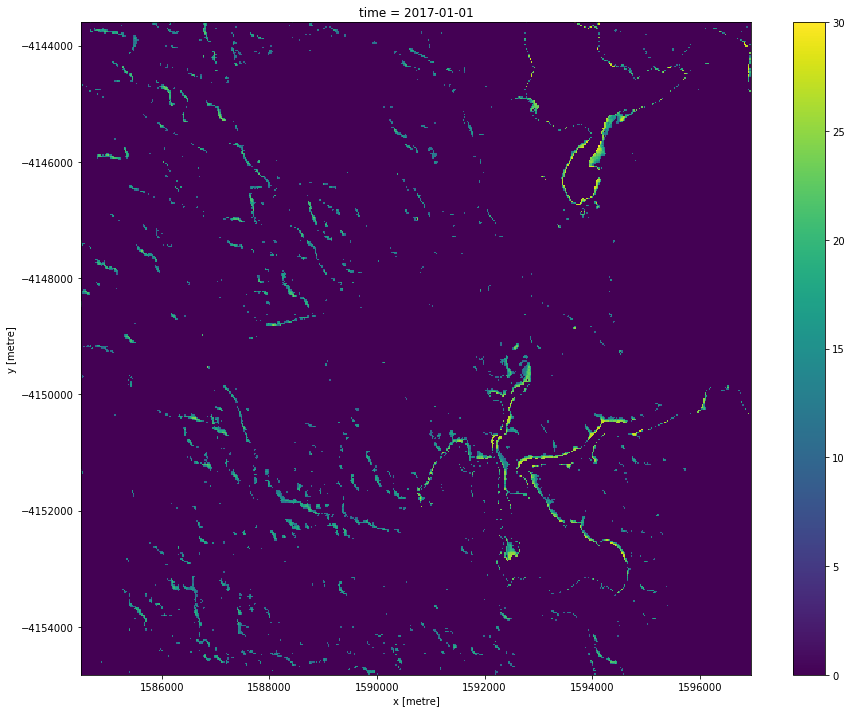

In [21]:
persistant_wet = wet_frequency.where(wet_frequency>precent_threhold,0)
persistant_wet = persistant_wet.where(wofs_filtered_summary.frequency<0.2,0)
persistant_wet.plot(figsize =(15,12))

In [22]:
persistant_wet

<xarray.DataArray (y: 449, x: 498, time: 1)>
array([[[0.],
        [0.],
        ...,
        [0.],
        [0.]],

       [[0.],
        [0.],
        ...,
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        ...,
        [0.],
        [0.]],

       [[0.],
        [0.],
        ...,
        [0.],
        [0.]]])
Coordinates:
  * y        (y) float64 -4.144e+06 -4.144e+06 ... -4.155e+06 -4.155e+06
  * x        (x) float64 1.585e+06 1.585e+06 1.585e+06 ... 1.597e+06 1.597e+06
  * time     (time) datetime64[ns] 2017-01-01

In [23]:
# Masked_lst8_data

In [24]:
# Data_out = Masked_lst8_data.drop(['coastal_aerosol','nir','swir1','swir2'])
# Data_out['inundated_veg'] = inundated_veg.astype('float64')
# # Data_out

In [25]:
# Data_out_once = Data_out.isel(time=0)
# Data_out_once['persistant_wet']=persistant_wet.astype('float64')
# Data_out_once['WOfS_frequency']=wofs_filtered_summary.frequency.isel(time=0).astype('float64')
# Data_out_once

In [26]:
#write_geotiff(filename, dataset, profile_override=None, time_index=None)
#write_geotiff('/g/data/u46/users/ck9738/Datasets/Tasselled_cap_tifs/Tiletest_-2_-14_2018.tif',Data_out_once)